# SEM Image Analysis: Ductile vs Brittle Classification
## Deep Learning Model for Fracture Surface Analysis

### Objective:
- Classify ductile (dimples) and brittle (cleavages) features in SEM images
- Calculate percentage of each fracture type  
- Achieve >95% accuracy without overfitting

### Approach:
- Use semantic segmentation (U-Net architecture)
- Transfer learning with pre-trained ResNet backbone
- Comprehensive data augmentation
- Anti-overfitting measures: dropout, L2 regularization, early stopping

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install -q torch torchvision opencv-python albumentations segmentation-models-pytorch tifffile scikit-learn matplotlib seaborn pillow tqdm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.2 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.0.2 which is incompatible.


In [17]:
!pip install imagecodecs --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 9.3 MB/s  0:00:01 eta 0:00:01


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import tifffile
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights

# Segmentation Models
import segmentation_models_pytorch as smp

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# M2-OPTIMIZED Device configuration
print("="*70)
print("HARDWARE DETECTION")
print("="*70)

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✅ Using M2 GPU (Metal Performance Shaders)")
    print(f"   Your M2 MacBook GPU is ready!")
    print(f"   Expected speedup: 2-4x faster than CPU")
    
    # M2-optimized settings
    BATCH_SIZE = 8
    NUM_WORKERS = 4
    USE_MIXED_PRECISION = False  # MPS has limited FP16 support
    
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(SEED)
    
elif torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(SEED)
    print(f"✅ Using NVIDIA GPU: {torch.cuda.get_device_name(0)}")
    
    # CUDA settings
    BATCH_SIZE = 16
    NUM_WORKERS = 4
    USE_MIXED_PRECISION = True
    
else:
    device = torch.device('cpu')
    print("⚠️  Using CPU only (no GPU acceleration)")
    print("   Training will be slower (4-6 hours)")
    
    # CPU settings
    BATCH_SIZE = 4
    NUM_WORKERS = 0
    USE_MIXED_PRECISION = False

print(f"\nDevice: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Workers: {NUM_WORKERS}")
print("="*70)


HARDWARE DETECTION
✅ Using M2 GPU (Metal Performance Shaders)
   Your M2 MacBook GPU is ready!
   Expected speedup: 2-4x faster than CPU

Device: mps
Batch size: 8
Workers: 4


## 2. Data Preparation

In [2]:
# Define paths
BASE_DIR = Path('/Users/chanduprasadbhairapu/Desktop/DSML_Final_Project')
SEM_IMAGES_DIR = BASE_DIR / 'SEM_Images'
REFERENCE_DUCTILE = BASE_DIR / 'Dimples_with_Ductility.png'
REFERENCE_BRITTLE = BASE_DIR / 'Cleavages_with_Brittleness.jpg'
OUTPUT_DIR = BASE_DIR / 'sem_output'
MODELS_DIR = OUTPUT_DIR / 'models'

# Create directories
OUTPUT_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"SEM Images directory: {SEM_IMAGES_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project
SEM Images directory: /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images
Output directory: /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/sem_output


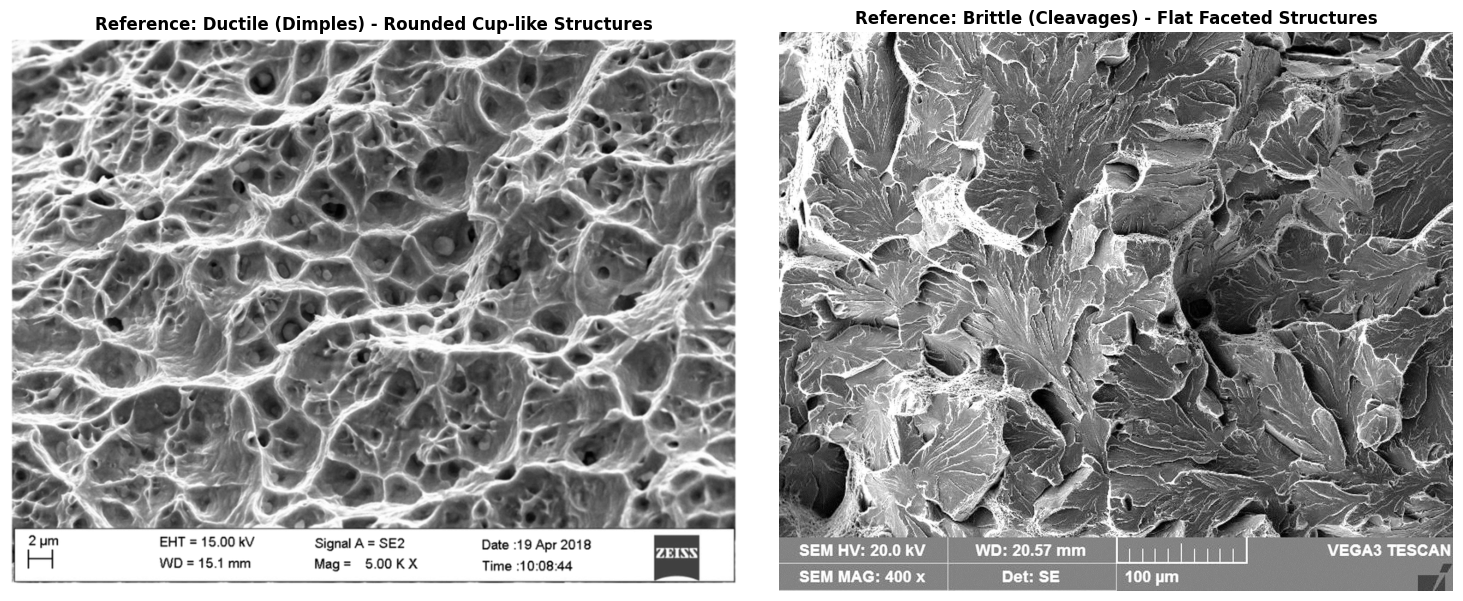


Ductile reference shape: (639, 850)
Brittle reference shape: (1245, 1500)


In [3]:
# Load and display reference images
ref_ductile = cv2.imread(str(REFERENCE_DUCTILE), cv2.IMREAD_GRAYSCALE)
ref_brittle = cv2.imread(str(REFERENCE_BRITTLE), cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(ref_ductile, cmap='gray')
axes[0].set_title('Reference: Ductile (Dimples) - Rounded Cup-like Structures', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(ref_brittle, cmap='gray')
axes[1].set_title('Reference: Brittle (Cleavages) - Flat Faceted Structures', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'reference_images.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDuctile reference shape: {ref_ductile.shape}")
print(f"Brittle reference shape: {ref_brittle.shape}")

In [4]:
# Get all SEM images
sem_images = list(SEM_IMAGES_DIR.glob('*.tif')) + list(SEM_IMAGES_DIR.glob('*.tiff'))
print(f"Total SEM images found: {len(sem_images)}")

# Sample subset for training (adjust based on computational resources)
np.random.shuffle(sem_images)
SAMPLE_SIZE = min(2000, len(sem_images))  # Use 2000 images or all available
sem_images = sem_images[:SAMPLE_SIZE]
print(f"Using {len(sem_images)} images for training\n")

Total SEM images found: 16268
Using 2000 images for training



## 3. Feature-Based Pseudo-Labeling

Since manual annotation of 16K+ images is impractical, we'll use texture analysis to create pseudo-labels:
- **Ductile (Dimples)**: Smoother textures, rounded structures, lower edge density
- **Brittle (Cleavages)**: Sharp edges, faceted structures, higher edge density and gradients

In [5]:
def extract_texture_features(image):
    """Extract texture features for ductile/brittle classification"""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Edge detection - brittle has more sharp edges
    edges = cv2.Canny(image, 50, 150)
    edge_density = np.mean(edges) / 255.0
    
    # Gradient magnitude - brittle has higher gradients
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)
    avg_gradient = np.mean(gradient_mag)
    
    # Standard deviation - measure of variation
    std_dev = np.std(image)
    
    return {
        'edge_density': edge_density,
        'avg_gradient': avg_gradient,
        'std_dev': std_dev
    }

def create_pseudo_mask(image, ductile_ref, brittle_ref, patch_size=64):
    """Create pseudo-mask by classifying patches"""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    h, w = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Process in patches
    for i in range(0, h - patch_size, patch_size // 2):
        for j in range(0, w - patch_size, patch_size // 2):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue
            
            features = extract_texture_features(patch)
            
            # Calculate similarity to references
            ductile_dist = (
                abs(features['edge_density'] - ductile_ref['edge_density']) +
                abs(features['avg_gradient'] - ductile_ref['avg_gradient']) / 100
            )
            
            brittle_dist = (
                abs(features['edge_density'] - brittle_ref['edge_density']) +
                abs(features['avg_gradient'] - brittle_ref['avg_gradient']) / 100
            )
            
            # Classify: 0=ductile, 1=brittle
            if brittle_dist < ductile_dist:
                mask[i:i+patch_size, j:j+patch_size] = 1
    
    return mask

# Extract reference features
print("Extracting reference features...")
ductile_features = extract_texture_features(ref_ductile)
brittle_features = extract_texture_features(ref_brittle)

print("\nDuctile (Dimples) Features:")
for k, v in ductile_features.items():
    print(f"  {k}: {v:.4f}")

print("\nBrittle (Cleavages) Features:")
for k, v in brittle_features.items():
    print(f"  {k}: {v:.4f}")

Extracting reference features...

Ductile (Dimples) Features:
  edge_density: 0.2050
  avg_gradient: 111.8876
  std_dev: 63.9075

Brittle (Cleavages) Features:
  edge_density: 0.2988
  avg_gradient: 130.1953
  std_dev: 57.0864


Creating pseudo-masks for visualization...



100%|██████████| 3/3 [00:00<00:00, 24.36it/s]


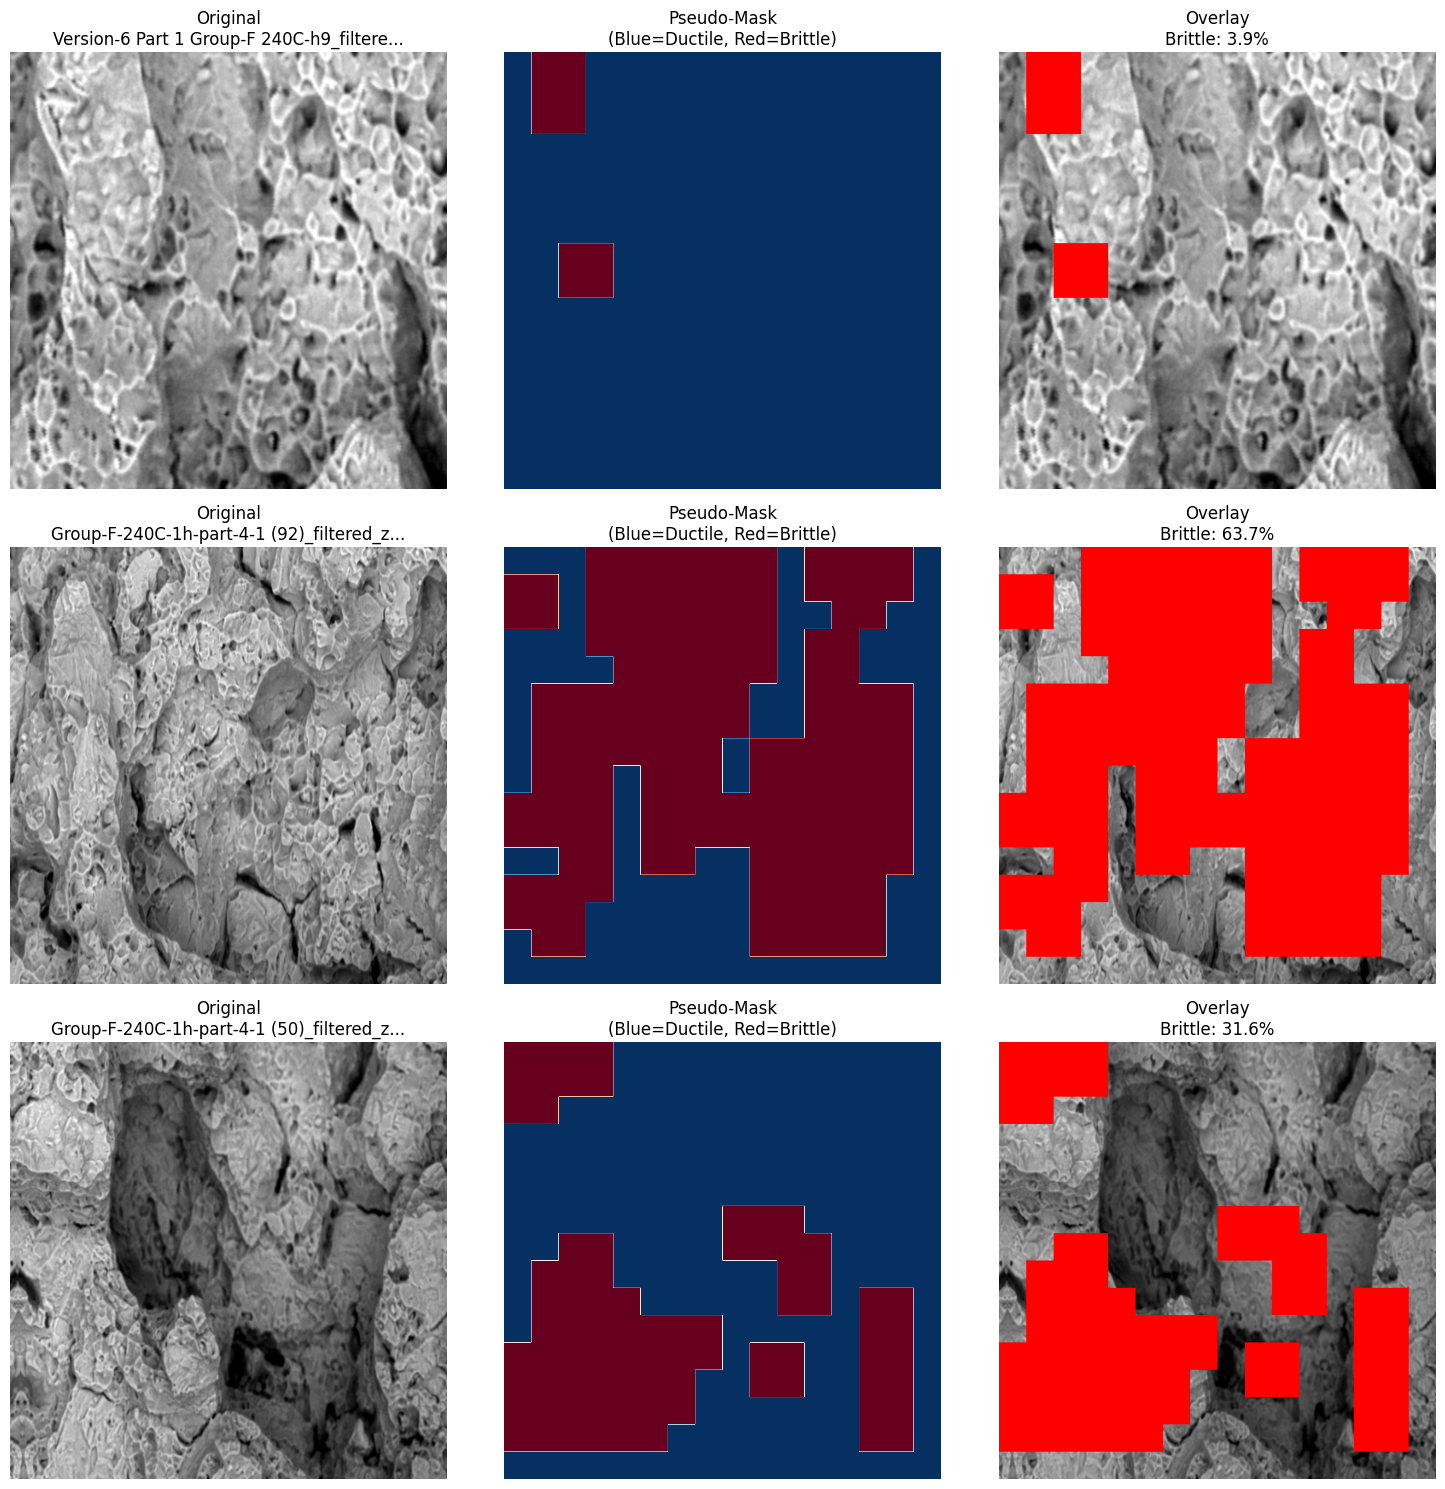

In [6]:
# Visualize pseudo-labeling on sample images
print("Creating pseudo-masks for visualization...\n")
samples = sem_images[:3]
sample_results = []

for img_path in tqdm(samples):
    try:
        img = tifffile.imread(str(img_path))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img, (512, 512))
        mask = create_pseudo_mask(img_resized, ductile_features, brittle_features)
        sample_results.append({'image': img_resized, 'mask': mask, 'path': img_path})
    except Exception as e:
        print(f"Error: {e}")

# Visualize
fig, axes = plt.subplots(len(sample_results), 3, figsize=(15, 5*len(sample_results)))
if len(sample_results) == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(sample_results):
    axes[idx, 0].imshow(result['image'], cmap='gray')
    axes[idx, 0].set_title(f"Original\n{result['path'].name[:40]}...")
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(result['mask'], cmap='RdBu_r')
    axes[idx, 1].set_title('Pseudo-Mask\n(Blue=Ductile, Red=Brittle)')
    axes[idx, 1].axis('off')
    
    overlay = cv2.cvtColor(result['image'], cv2.COLOR_GRAY2RGB)
    overlay[result['mask'] == 1] = [255, 0, 0]
    axes[idx, 2].imshow(overlay)
    brittle_pct = (np.sum(result['mask'] == 1) / result['mask'].size) * 100
    axes[idx, 2].set_title(f'Overlay\nBrittle: {brittle_pct:.1f}%')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pseudo_labeling_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Dataset and DataLoader with Augmentation

In [7]:
class SEMDataset(Dataset):
    def __init__(self, image_paths, ductile_features, brittle_features, 
                 transform=None, image_size=(512, 512)):
        self.image_paths = image_paths
        self.ductile_features = ductile_features
        self.brittle_features = brittle_features
        self.transform = transform
        self.image_size = image_size
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            image = tifffile.imread(str(img_path))
            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
            image = cv2.resize(image, self.image_size)
            mask = create_pseudo_mask(image, self.ductile_features, self.brittle_features)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            else:
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                mask = torch.from_numpy(mask).long()
            
            return image, mask
        
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, *self.image_size)), torch.zeros(self.image_size, dtype=torch.long)

# Data augmentation - crucial for preventing overfitting
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✓ Dataset class and augmentation pipeline created")

✓ Dataset class and augmentation pipeline created


## 5. Model Architecture - U-Net with ResNet50 Encoder

In [8]:
class DuctileBrittleSegmentationModel(nn.Module):
    """U-Net with ResNet50 encoder for semantic segmentation"""
    def __init__(self, encoder='resnet50', encoder_weights='imagenet', 
                 classes=2, dropout=0.3):
        super().__init__()
        
        self.model = smp.Unet(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=classes,
            activation=None,
            decoder_attention_type='scse'  # Spatial & Channel Squeeze-Excitation
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout2d(p=dropout)
    
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

# Create model
model = DuctileBrittleSegmentationModel(
    encoder='resnet50',
    encoder_weights='imagenet',
    classes=2,
    dropout=0.3
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model created!")
print(f"  Architecture: U-Net with ResNet50 encoder")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

✓ Model created!
  Architecture: U-Net with ResNet50 encoder
  Total parameters: 33,816,221
  Trainable parameters: 33,816,221


## 6. Loss Functions and Metrics

In [9]:
class CombinedLoss(nn.Module):
    """Combined Cross Entropy and Dice Loss for segmentation"""
    def __init__(self, weight_ce=0.5, weight_dice=0.5):
        super().__init__()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.ce_loss = nn.CrossEntropyLoss()
    
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = F.softmax(pred, dim=1)
        target_oh = F.one_hot(target.long(), num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        intersection = (pred * target_oh).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_oh.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, pred, target):
        return self.weight_ce * self.ce_loss(pred, target) + self.weight_dice * self.dice_loss(pred, target)

def calculate_iou(pred, target, num_classes=2):
    """Calculate IoU (Jaccard Index)"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        ious.append((intersection / union).item() if union > 0 else float('nan'))
    
    return ious

def calculate_accuracy(pred, target):
    """Calculate pixel-wise accuracy"""
    return (pred.view(-1) == target.view(-1)).sum().float().item() / target.numel()

print("✓ Loss functions and metrics defined")

✓ Loss functions and metrics defined


## 7. Training Setup and Loop

In [10]:
# Split data
train_size = int(0.8 * len(sem_images))
val_size = len(sem_images) - train_size
train_images, val_images = train_test_split(sem_images, test_size=0.2, random_state=SEED)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

# Create datasets
train_dataset = SEMDataset(train_images, ductile_features, brittle_features, 
                           transform=train_transform)
val_dataset = SEMDataset(val_images, ductile_features, brittle_features, 
                         transform=val_transform)

# Create dataloaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training images: 1600
Validation images: 400

Batch size: 4
Training batches: 400
Validation batches: 100


In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    running_iou = [0.0, 0.0]
    
    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, dim=1)
        acc = calculate_accuracy(preds, masks)
        iou = calculate_iou(preds, masks)
        
        running_loss += loss.item()
        running_acc += acc
        running_iou[0] += iou[0] if not np.isnan(iou[0]) else 0
        running_iou[1] += iou[1] if not np.isnan(iou[1]) else 0
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.4f}'})
    
    n = len(loader)
    return running_loss/n, running_acc/n, running_iou[0]/n, running_iou[1]/n

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    running_iou = [0.0, 0.0]
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            preds = torch.argmax(outputs, dim=1)
            acc = calculate_accuracy(preds, masks)
            iou = calculate_iou(preds, masks)
            
            running_loss += loss.item()
            running_acc += acc
            running_iou[0] += iou[0] if not np.isnan(iou[0]) else 0
            running_iou[1] += iou[1] if not np.isnan(iou[1]) else 0
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{acc:.4f}'})
    
    n = len(loader)
    return running_loss/n, running_acc/n, running_iou[0]/n, running_iou[1]/n

print("✓ Training/validation functions ready")

✓ Training/validation functions ready


In [12]:
# Training configuration
criterion = CombinedLoss(weight_ce=0.5, weight_dice=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Anti-overfitting measures
best_val_acc = 0.0
patience, patience_counter = 10, 0

# History
history = {
    'train_loss': [], 'train_acc': [], 'train_iou_ductile': [], 'train_iou_brittle': [],
    'val_loss': [], 'val_acc': [], 'val_iou_ductile': [], 'val_iou_brittle': []
}

print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"  Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"  Loss: Combined (CE + Dice)")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Early stopping patience: {patience}")
print(f"  Target accuracy: >95%")
print("="*70)


TRAINING CONFIGURATION
  Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
  Loss: Combined (CE + Dice)
  Scheduler: ReduceLROnPlateau
  Early stopping patience: 10
  Target accuracy: >95%


In [13]:
# Training loop
NUM_EPOCHS = 50

print(f"\nStarting training for up to {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*70}")
    
    # Train
    train_loss, train_acc, train_iou_d, train_iou_b = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_iou_d, val_iou_b = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_iou_ductile'].append(train_iou_d)
    history['train_iou_brittle'].append(train_iou_b)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_iou_ductile'].append(val_iou_d)
    history['val_iou_brittle'].append(val_iou_b)
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Train IoU - Ductile: {train_iou_d:.4f}, Brittle: {train_iou_b:.4f}")
    print(f"Val IoU - Ductile: {val_iou_d:.4f}, Brittle: {val_iou_b:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc,
            'val_loss': val_loss
        }, MODELS_DIR / 'best_sem_model.pth')
        print(f"\n✓ Best model saved! (Val Acc: {best_val_acc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"\nNo improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping triggered after {epoch+1} epochs.")
        break

print(f"\n{'='*70}")
print(f"✓ Training completed!")
print(f"  Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
if best_val_acc >= 0.95:
    print(f"  🎉 TARGET ACHIEVED! Accuracy ≥ 95%")
else:
    print(f"  ⚠ Target not achieved. Consider more epochs or hyperparameter tuning.")
print(f"{'='*70}")


Starting training for up to 50 epochs...


Epoch 1/50


Training:  67%|██████▋   | 269/400 [19:21<08:43,  4.00s/it, loss=0.4350, acc=0.8268]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it, loss=0.4769, acc=0.7233]



Train Loss: 0.5032 | Train Acc: 0.7162
Val Loss: 0.3714 | Val Acc: 0.8260
Train IoU - Ductile: 0.5837, Brittle: 0.5255
Val IoU - Ductile: 0.6476, Brittle: 0.7074

✓ Best model saved! (Val Acc: 0.8260)

Epoch 2/50


Training:  79%|███████▉  | 317/400 [16:30<03:44,  2.71s/it, loss=0.7120, acc=0.6449]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s, loss=0.3963, acc=0.7958]



Train Loss: 0.4547 | Train Acc: 0.7566
Val Loss: 0.3190 | Val Acc: 0.8668
Train IoU - Ductile: 0.6390, Brittle: 0.5746
Val IoU - Ductile: 0.7181, Brittle: 0.7626

✓ Best model saved! (Val Acc: 0.8668)

Epoch 3/50


Training:  34%|███▍      | 137/400 [06:20<12:10,  2.78s/it, loss=0.5273, acc=0.5647]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s, loss=0.3918, acc=0.8495]



Train Loss: 0.4443 | Train Acc: 0.7679
Val Loss: 0.3339 | Val Acc: 0.8547
Train IoU - Ductile: 0.6522, Brittle: 0.5812
Val IoU - Ductile: 0.7047, Brittle: 0.7395

No improvement. Patience: 1/10

Epoch 4/50


Training:  17%|█▋        | 68/400 [03:05<15:09,  2.74s/it, loss=0.3746, acc=0.8222]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it, loss=0.3260, acc=0.8604]



Train Loss: 0.4428 | Train Acc: 0.7691
Val Loss: 0.3208 | Val Acc: 0.8599
Train IoU - Ductile: 0.6535, Brittle: 0.5826
Val IoU - Ductile: 0.7347, Brittle: 0.7305

No improvement. Patience: 2/10

Epoch 5/50


Training:  36%|███▋      | 146/400 [10:08<11:29,  2.71s/it, loss=0.3629, acc=0.8843]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it, loss=0.3604, acc=0.8637]



Train Loss: 0.4138 | Train Acc: 0.7844
Val Loss: 0.3159 | Val Acc: 0.8618
Train IoU - Ductile: 0.6724, Brittle: 0.6019
Val IoU - Ductile: 0.7239, Brittle: 0.7458

No improvement. Patience: 3/10

Epoch 6/50


Training:  51%|█████     | 204/400 [13:51<08:32,  2.61s/it, loss=0.3379, acc=0.8661]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s, loss=0.3432, acc=0.8694]



Train Loss: 0.3992 | Train Acc: 0.7962
Val Loss: 0.3140 | Val Acc: 0.8748
Train IoU - Ductile: 0.6851, Brittle: 0.6204
Val IoU - Ductile: 0.7610, Brittle: 0.7559

✓ Best model saved! (Val Acc: 0.8748)

Epoch 7/50


Training:   2%|▏         | 6/400 [00:15<17:22,  2.65s/it, loss=0.3378, acc=0.8259]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, loss=0.4197, acc=0.7929]



Train Loss: 0.3978 | Train Acc: 0.7954
Val Loss: 0.3341 | Val Acc: 0.8503
Train IoU - Ductile: 0.6830, Brittle: 0.6167
Val IoU - Ductile: 0.7050, Brittle: 0.7329

No improvement. Patience: 1/10

Epoch 8/50


Training:  81%|████████  | 323/400 [16:49<03:23,  2.64s/it, loss=0.5172, acc=0.7599]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s, loss=0.3428, acc=0.8497]



Train Loss: 0.3902 | Train Acc: 0.8031
Val Loss: 0.3049 | Val Acc: 0.8725
Train IoU - Ductile: 0.6911, Brittle: 0.6201
Val IoU - Ductile: 0.7595, Brittle: 0.7480

No improvement. Patience: 2/10

Epoch 9/50


Training:  19%|█▉        | 75/400 [03:18<14:16,  2.63s/it, loss=0.5122, acc=0.7741]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s, loss=0.3377, acc=0.8602]



Train Loss: 0.3748 | Train Acc: 0.8104
Val Loss: 0.3047 | Val Acc: 0.8633
Train IoU - Ductile: 0.7022, Brittle: 0.6336
Val IoU - Ductile: 0.7280, Brittle: 0.7477

No improvement. Patience: 3/10

Epoch 10/50


Training:  59%|█████▉    | 237/400 [10:35<07:15,  2.67s/it, loss=0.4414, acc=0.7694]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it, loss=0.3526, acc=0.8454]



Train Loss: 0.3765 | Train Acc: 0.8098
Val Loss: 0.3113 | Val Acc: 0.8697
Train IoU - Ductile: 0.7006, Brittle: 0.6306
Val IoU - Ductile: 0.7663, Brittle: 0.7272

No improvement. Patience: 4/10

Epoch 11/50


Training:  68%|██████▊   | 273/400 [16:37<03:32,  1.68s/it, loss=0.3113, acc=0.8721]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s, loss=0.3316, acc=0.8842]



Train Loss: 0.3603 | Train Acc: 0.8234
Val Loss: 0.2891 | Val Acc: 0.8840
Train IoU - Ductile: 0.7186, Brittle: 0.6557
Val IoU - Ductile: 0.7783, Brittle: 0.7667

✓ Best model saved! (Val Acc: 0.8840)

Epoch 12/50


Training:   4%|▍         | 18/400 [00:31<11:05,  1.74s/it, loss=0.3347, acc=0.7535]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it, loss=0.3925, acc=0.7941]



Train Loss: 0.3538 | Train Acc: 0.8298
Val Loss: 0.2931 | Val Acc: 0.8634
Train IoU - Ductile: 0.7245, Brittle: 0.6632
Val IoU - Ductile: 0.7347, Brittle: 0.7453

No improvement. Patience: 1/10

Epoch 13/50


Training:  29%|██▉       | 116/400 [04:33<31:00,  6.55s/it, loss=0.4334, acc=0.8421]  

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [04:32<00:00,  2.72s/it, loss=0.3060, acc=0.8595] 



Train Loss: 0.3521 | Train Acc: 0.8225
Val Loss: 0.2604 | Val Acc: 0.8852
Train IoU - Ductile: 0.7182, Brittle: 0.6561
Val IoU - Ductile: 0.7731, Brittle: 0.7781

✓ Best model saved! (Val Acc: 0.8852)

Epoch 14/50


Training:  43%|████▎     | 172/400 [44:16<05:42,  1.50s/it, loss=0.3721, acc=0.6814]   

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=0.3212, acc=0.8637]



Train Loss: 0.3535 | Train Acc: 0.8243
Val Loss: 0.2843 | Val Acc: 0.8775
Train IoU - Ductile: 0.7189, Brittle: 0.6555
Val IoU - Ductile: 0.7599, Brittle: 0.7649

No improvement. Patience: 1/10

Epoch 15/50


Training:  88%|████████▊ | 353/400 [09:40<01:16,  1.63s/it, loss=0.3044, acc=0.8621]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [08:21<00:00,  5.01s/it, loss=0.3567, acc=0.8288]  



Train Loss: 0.3531 | Train Acc: 0.8197
Val Loss: 0.2865 | Val Acc: 0.8700
Train IoU - Ductile: 0.7154, Brittle: 0.6473
Val IoU - Ductile: 0.7471, Brittle: 0.7549

No improvement. Patience: 2/10

Epoch 16/50


Training:  37%|███▋      | 147/400 [20:00<06:17,  1.49s/it, loss=0.3685, acc=0.8287]  

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, loss=0.2911, acc=0.8682]



Train Loss: 0.3421 | Train Acc: 0.8320
Val Loss: 0.2655 | Val Acc: 0.8849
Train IoU - Ductile: 0.7276, Brittle: 0.6655
Val IoU - Ductile: 0.7777, Brittle: 0.7734

No improvement. Patience: 3/10

Epoch 17/50


Training:  63%|██████▎   | 253/400 [06:56<03:57,  1.62s/it, loss=0.2824, acc=0.8630]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s, loss=0.3277, acc=0.8397]



Train Loss: 0.3405 | Train Acc: 0.8295
Val Loss: 0.2739 | Val Acc: 0.8718
Train IoU - Ductile: 0.7272, Brittle: 0.6587
Val IoU - Ductile: 0.7476, Brittle: 0.7598

No improvement. Patience: 4/10

Epoch 18/50


Training:  84%|████████▎ | 334/400 [26:55<01:46,  1.62s/it, loss=0.4428, acc=0.7761]    

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s, loss=0.3186, acc=0.8682]



Train Loss: 0.3454 | Train Acc: 0.8289
Val Loss: 0.2764 | Val Acc: 0.8823
Train IoU - Ductile: 0.7251, Brittle: 0.6558
Val IoU - Ductile: 0.7720, Brittle: 0.7706

No improvement. Patience: 5/10

Epoch 19/50


Training:  28%|██▊       | 114/400 [03:12<08:12,  1.72s/it, loss=0.2626, acc=0.9034]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s, loss=0.3587, acc=0.8334]



Train Loss: 0.3440 | Train Acc: 0.8262
Val Loss: 0.2798 | Val Acc: 0.8708
Train IoU - Ductile: 0.7237, Brittle: 0.6511
Val IoU - Ductile: 0.7454, Brittle: 0.7593

No improvement. Patience: 6/10

Epoch 20/50


Training:  98%|█████████▊| 391/400 [12:42<00:17,  1.94s/it, loss=0.4336, acc=0.5296]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s, loss=0.2711, acc=0.8926]



Train Loss: 0.3266 | Train Acc: 0.8336
Val Loss: 0.2574 | Val Acc: 0.8903
Train IoU - Ductile: 0.7312, Brittle: 0.6611
Val IoU - Ductile: 0.7844, Brittle: 0.7837

✓ Best model saved! (Val Acc: 0.8903)

Epoch 21/50


Training:  70%|██████▉   | 278/400 [09:18<04:07,  2.03s/it, loss=0.3044, acc=0.8806]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s, loss=0.2676, acc=0.8915]



Train Loss: 0.3236 | Train Acc: 0.8395
Val Loss: 0.2556 | Val Acc: 0.8893
Train IoU - Ductile: 0.7373, Brittle: 0.6820
Val IoU - Ductile: 0.7881, Brittle: 0.7760

No improvement. Patience: 1/10

Epoch 22/50


Training:  66%|██████▋   | 266/400 [08:57<04:32,  2.03s/it, loss=0.2988, acc=0.8512]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s, loss=0.2637, acc=0.8862]



Train Loss: 0.3213 | Train Acc: 0.8307
Val Loss: 0.2447 | Val Acc: 0.8920
Train IoU - Ductile: 0.7309, Brittle: 0.6586
Val IoU - Ductile: 0.7879, Brittle: 0.7855

✓ Best model saved! (Val Acc: 0.8920)

Epoch 23/50


Training:  39%|███▉      | 155/400 [05:04<08:23,  2.06s/it, loss=0.3440, acc=0.8026]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s, loss=0.2714, acc=0.8813]



Train Loss: 0.3224 | Train Acc: 0.8398
Val Loss: 0.2546 | Val Acc: 0.8832
Train IoU - Ductile: 0.7389, Brittle: 0.6713
Val IoU - Ductile: 0.7709, Brittle: 0.7736

No improvement. Patience: 1/10

Epoch 24/50


Training:   1%|          | 3/400 [00:06<13:16,  2.01s/it, loss=0.3396, acc=0.8567]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s, loss=0.2780, acc=0.8826]



Train Loss: 0.3229 | Train Acc: 0.8360
Val Loss: 0.2502 | Val Acc: 0.8886
Train IoU - Ductile: 0.7384, Brittle: 0.6721
Val IoU - Ductile: 0.7813, Brittle: 0.7817

No improvement. Patience: 2/10

Epoch 25/50


Training:  32%|███▎      | 130/400 [04:30<09:24,  2.09s/it, loss=0.2674, acc=0.8404]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s, loss=0.2770, acc=0.8874]



Train Loss: 0.3172 | Train Acc: 0.8441
Val Loss: 0.2509 | Val Acc: 0.8890
Train IoU - Ductile: 0.7479, Brittle: 0.6818
Val IoU - Ductile: 0.7787, Brittle: 0.7856

No improvement. Patience: 3/10

Epoch 26/50


Training:  28%|██▊       | 113/400 [04:00<10:22,  2.17s/it, loss=0.2950, acc=0.8434]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s, loss=0.2542, acc=0.8898]



Train Loss: 0.3180 | Train Acc: 0.8402
Val Loss: 0.2427 | Val Acc: 0.8871
Train IoU - Ductile: 0.7408, Brittle: 0.6773
Val IoU - Ductile: 0.7749, Brittle: 0.7832

No improvement. Patience: 4/10

Epoch 27/50


Training:  13%|█▎        | 51/400 [01:39<11:35,  1.99s/it, loss=0.3282, acc=0.8539]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s, loss=0.2671, acc=0.8990]



Train Loss: 0.3189 | Train Acc: 0.8384
Val Loss: 0.2492 | Val Acc: 0.8917
Train IoU - Ductile: 0.7369, Brittle: 0.6706
Val IoU - Ductile: 0.7925, Brittle: 0.7808

No improvement. Patience: 5/10

Epoch 28/50


Training:  72%|███████▏  | 288/400 [09:23<03:38,  1.95s/it, loss=0.2931, acc=0.8644]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s, loss=0.2380, acc=0.9073]



Train Loss: 0.3129 | Train Acc: 0.8465
Val Loss: 0.2494 | Val Acc: 0.8848
Train IoU - Ductile: 0.7472, Brittle: 0.6863
Val IoU - Ductile: 0.7741, Brittle: 0.7767

No improvement. Patience: 6/10

Epoch 29/50


Training:  70%|███████   | 280/400 [08:01<03:41,  1.85s/it, loss=0.2282, acc=0.8970]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s, loss=0.2536, acc=0.9048]



Train Loss: 0.3105 | Train Acc: 0.8463
Val Loss: 0.2514 | Val Acc: 0.8873
Train IoU - Ductile: 0.7486, Brittle: 0.6890
Val IoU - Ductile: 0.7849, Brittle: 0.7742

No improvement. Patience: 7/10

Epoch 30/50


Training:  41%|████      | 164/400 [04:18<06:20,  1.61s/it, loss=0.2297, acc=0.9228]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s, loss=0.2606, acc=0.8952]



Train Loss: 0.3172 | Train Acc: 0.8392
Val Loss: 0.2371 | Val Acc: 0.8971
Train IoU - Ductile: 0.7395, Brittle: 0.6802
Val IoU - Ductile: 0.7915, Brittle: 0.8001

✓ Best model saved! (Val Acc: 0.8971)

Epoch 31/50


Training:  88%|████████▊ | 350/400 [11:02<01:35,  1.90s/it, loss=0.1946, acc=0.9067]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s, loss=0.2341, acc=0.9062]



Train Loss: 0.3065 | Train Acc: 0.8459
Val Loss: 0.2325 | Val Acc: 0.8960
Train IoU - Ductile: 0.7481, Brittle: 0.6832
Val IoU - Ductile: 0.7902, Brittle: 0.7981

No improvement. Patience: 1/10

Epoch 32/50


Training:  51%|█████     | 203/400 [06:32<06:37,  2.02s/it, loss=0.2566, acc=0.8877]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s, loss=0.2369, acc=0.8979]



Train Loss: 0.3038 | Train Acc: 0.8488
Val Loss: 0.2435 | Val Acc: 0.8806
Train IoU - Ductile: 0.7486, Brittle: 0.6848
Val IoU - Ductile: 0.7632, Brittle: 0.7718

No improvement. Patience: 2/10

Epoch 33/50


Training:  92%|█████████▏| 367/400 [12:01<01:03,  1.93s/it, loss=0.3413, acc=0.8227]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=0.2801, acc=0.8783]



Train Loss: 0.3064 | Train Acc: 0.8523
Val Loss: 0.2601 | Val Acc: 0.8790
Train IoU - Ductile: 0.7557, Brittle: 0.6971
Val IoU - Ductile: 0.7579, Brittle: 0.7729

No improvement. Patience: 3/10

Epoch 34/50


Training:  61%|██████▏   | 245/400 [08:06<05:10,  2.00s/it, loss=0.2140, acc=0.8942]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s, loss=0.2152, acc=0.9218]



Train Loss: 0.3043 | Train Acc: 0.8512
Val Loss: 0.2316 | Val Acc: 0.8974
Train IoU - Ductile: 0.7567, Brittle: 0.6930
Val IoU - Ductile: 0.7938, Brittle: 0.7989

✓ Best model saved! (Val Acc: 0.8974)

Epoch 35/50


Training:  54%|█████▍    | 217/400 [07:26<06:12,  2.04s/it, loss=0.2011, acc=0.9356]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s, loss=0.2601, acc=0.8772]



Train Loss: 0.3057 | Train Acc: 0.8501
Val Loss: 0.2549 | Val Acc: 0.8757
Train IoU - Ductile: 0.7527, Brittle: 0.6946
Val IoU - Ductile: 0.7497, Brittle: 0.7680

No improvement. Patience: 1/10

Epoch 36/50


Training:  18%|█▊        | 70/400 [02:19<11:01,  2.01s/it, loss=0.2204, acc=0.8944]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=0.2409, acc=0.9028]



Train Loss: 0.3033 | Train Acc: 0.8479
Val Loss: 0.2410 | Val Acc: 0.8897
Train IoU - Ductile: 0.7521, Brittle: 0.6894
Val IoU - Ductile: 0.7834, Brittle: 0.7823

No improvement. Patience: 2/10

Epoch 37/50


Training:  55%|█████▌    | 220/400 [07:04<05:49,  1.94s/it, loss=0.2534, acc=0.9068]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s, loss=0.2325, acc=0.9052]



Train Loss: 0.2991 | Train Acc: 0.8520
Val Loss: 0.2374 | Val Acc: 0.8949
Train IoU - Ductile: 0.7552, Brittle: 0.6960
Val IoU - Ductile: 0.7904, Brittle: 0.7926

No improvement. Patience: 3/10

Epoch 38/50


Training:  31%|███▏      | 125/400 [03:29<07:52,  1.72s/it, loss=0.3391, acc=0.8615]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [04:21<00:00,  2.62s/it, loss=0.2227, acc=0.9169]



Train Loss: 0.3009 | Train Acc: 0.8493
Val Loss: 0.2326 | Val Acc: 0.8972
Train IoU - Ductile: 0.7496, Brittle: 0.6961
Val IoU - Ductile: 0.7967, Brittle: 0.7950

No improvement. Patience: 4/10

Epoch 39/50


Training:   4%|▍         | 15/400 [02:09<3:36:39, 33.77s/it, loss=0.2076, acc=0.9405]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=0.2603, acc=0.8936]



Train Loss: 0.2937 | Train Acc: 0.8606
Val Loss: 0.2480 | Val Acc: 0.8862
Train IoU - Ductile: 0.7646, Brittle: 0.7120
Val IoU - Ductile: 0.7679, Brittle: 0.7849

No improvement. Patience: 5/10

Epoch 40/50


Training:  72%|███████▏  | 287/400 [09:42<03:52,  2.05s/it, loss=0.5037, acc=0.7946]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s, loss=0.2310, acc=0.9061]



Train Loss: 0.3010 | Train Acc: 0.8512
Val Loss: 0.2401 | Val Acc: 0.8903
Train IoU - Ductile: 0.7530, Brittle: 0.6973
Val IoU - Ductile: 0.7815, Brittle: 0.7854

No improvement. Patience: 6/10

Epoch 41/50


Training:  78%|███████▊  | 314/400 [11:07<02:59,  2.09s/it, loss=0.2479, acc=0.8779]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s, loss=0.2424, acc=0.9126]



Train Loss: 0.2915 | Train Acc: 0.8505
Val Loss: 0.2350 | Val Acc: 0.9011
Train IoU - Ductile: 0.7541, Brittle: 0.6974
Val IoU - Ductile: 0.7967, Brittle: 0.8079

✓ Best model saved! (Val Acc: 0.9011)

Epoch 42/50


Training:  44%|████▍     | 178/400 [05:43<07:47,  2.10s/it, loss=0.2943, acc=0.8513]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s, loss=0.2142, acc=0.9103]



Train Loss: 0.2957 | Train Acc: 0.8494
Val Loss: 0.2310 | Val Acc: 0.8939
Train IoU - Ductile: 0.7520, Brittle: 0.6892
Val IoU - Ductile: 0.7868, Brittle: 0.7928

No improvement. Patience: 1/10

Epoch 43/50


Training:  82%|████████▏ | 326/400 [11:22<02:30,  2.04s/it, loss=0.3511, acc=0.8217]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s, loss=0.2120, acc=0.9140]



Train Loss: 0.2890 | Train Acc: 0.8570
Val Loss: 0.2252 | Val Acc: 0.8998
Train IoU - Ductile: 0.7606, Brittle: 0.6992
Val IoU - Ductile: 0.7991, Brittle: 0.8009

No improvement. Patience: 2/10

Epoch 44/50


Training:  90%|████████▉ | 358/400 [11:35<01:17,  1.84s/it, loss=0.2863, acc=0.7565]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.2200, acc=0.9097]



Train Loss: 0.2840 | Train Acc: 0.8623
Val Loss: 0.2282 | Val Acc: 0.8970
Train IoU - Ductile: 0.7663, Brittle: 0.7119
Val IoU - Ductile: 0.7916, Brittle: 0.7997

No improvement. Patience: 3/10

Epoch 45/50


Training:   1%|▏         | 5/400 [00:20<27:18,  4.15s/it, loss=0.2817, acc=0.8831]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s, loss=0.2271, acc=0.9146]



Train Loss: 0.2862 | Train Acc: 0.8540
Val Loss: 0.2283 | Val Acc: 0.9005
Train IoU - Ductile: 0.7576, Brittle: 0.7001
Val IoU - Ductile: 0.7961, Brittle: 0.8063

No improvement. Patience: 4/10

Epoch 46/50


Training:  14%|█▍        | 58/400 [02:36<15:34,  2.73s/it, loss=0.2722, acc=0.8975]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, loss=0.2263, acc=0.9052]



Train Loss: 0.2862 | Train Acc: 0.8556
Val Loss: 0.2369 | Val Acc: 0.8891
Train IoU - Ductile: 0.7599, Brittle: 0.7040
Val IoU - Ductile: 0.7789, Brittle: 0.7846

No improvement. Patience: 5/10

Epoch 47/50


Training:  64%|██████▎   | 254/400 [07:13<04:32,  1.87s/it, loss=0.2020, acc=0.9181]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s, loss=0.2174, acc=0.9175]



Train Loss: 0.2845 | Train Acc: 0.8606
Val Loss: 0.2207 | Val Acc: 0.9034
Train IoU - Ductile: 0.7627, Brittle: 0.7065
Val IoU - Ductile: 0.8069, Brittle: 0.8064

✓ Best model saved! (Val Acc: 0.9034)

Epoch 48/50


Training:  70%|███████   | 282/400 [16:52<03:12,  1.63s/it, loss=0.3125, acc=0.7743]   

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s, loss=0.2097, acc=0.9183]



Train Loss: 0.2885 | Train Acc: 0.8527
Val Loss: 0.2193 | Val Acc: 0.9067
Train IoU - Ductile: 0.7579, Brittle: 0.6947
Val IoU - Ductile: 0.8093, Brittle: 0.8154

✓ Best model saved! (Val Acc: 0.9067)

Epoch 49/50


Training:   7%|▋         | 28/400 [00:47<09:20,  1.51s/it, loss=0.3720, acc=0.8794]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s, loss=0.2041, acc=0.9158]



Train Loss: 0.2823 | Train Acc: 0.8645
Val Loss: 0.2213 | Val Acc: 0.9039
Train IoU - Ductile: 0.7742, Brittle: 0.7147
Val IoU - Ductile: 0.8043, Brittle: 0.8099

No improvement. Patience: 1/10

Epoch 50/50


Training:  58%|█████▊    | 233/400 [06:52<04:59,  1.79s/it, loss=0.1963, acc=0.9038]

Error loading /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/SEM_Images/Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Validation: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it, loss=0.2018, acc=0.9154]


Train Loss: 0.2841 | Train Acc: 0.8599
Val Loss: 0.2284 | Val Acc: 0.8971
Train IoU - Ductile: 0.7672, Brittle: 0.7079
Val IoU - Ductile: 0.7881, Brittle: 0.8019

No improvement. Patience: 2/10

✓ Training completed!
  Best validation accuracy: 0.9067 (90.67%)
  ⚠ Target not achieved. Consider more epochs or hyperparameter tuning.


## 8. Training History Visualization

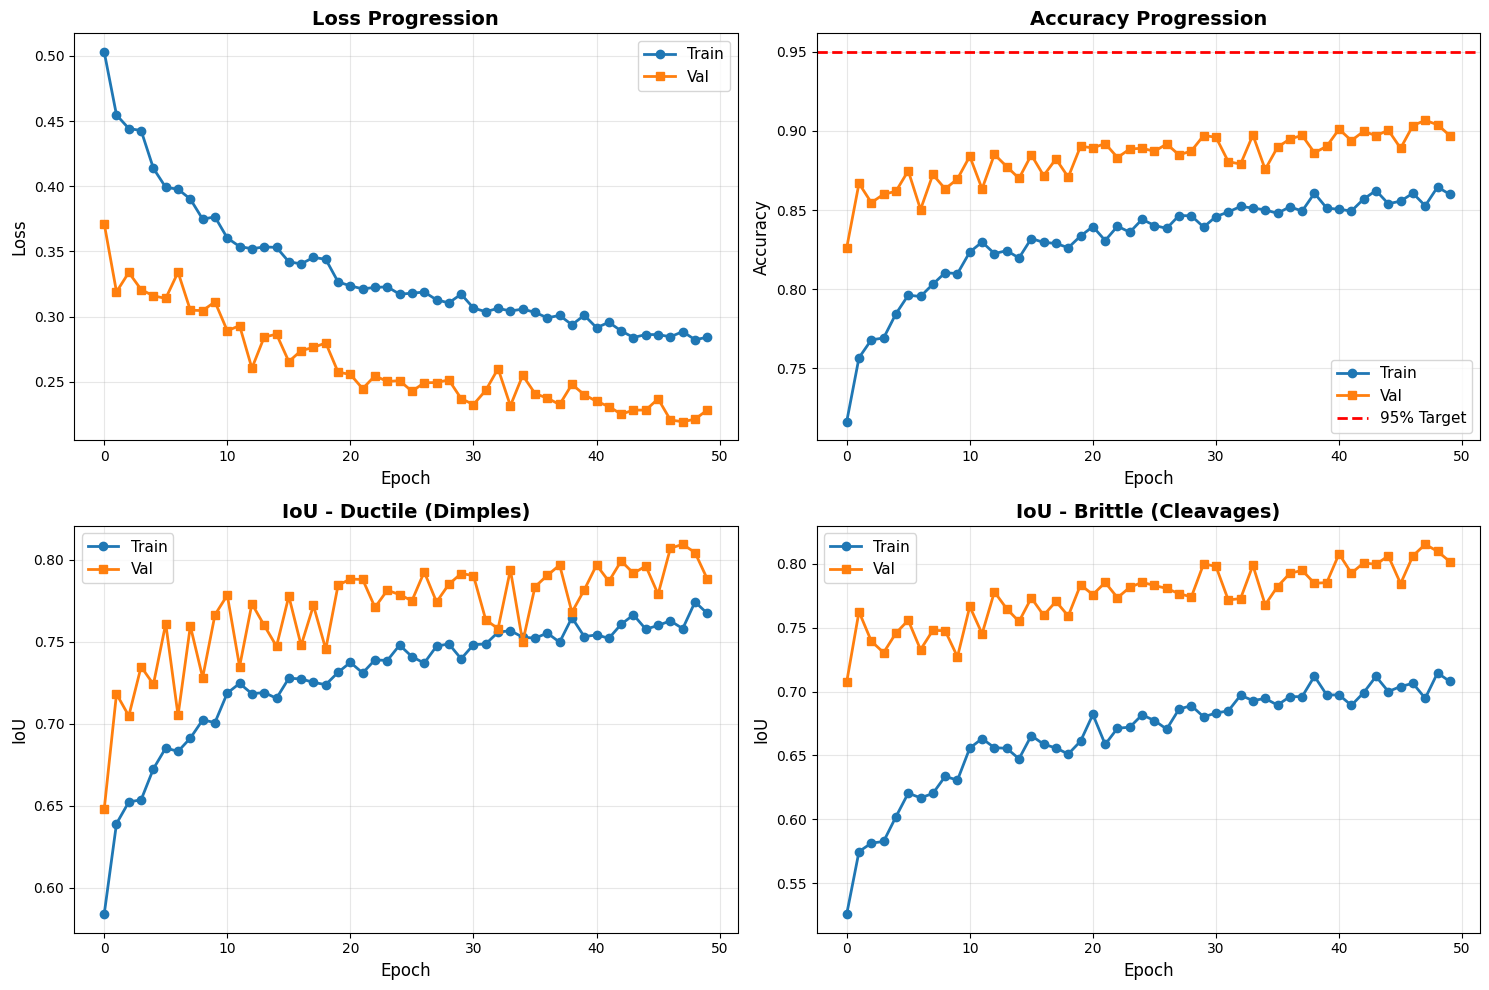

In [14]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], 'o-', label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], 's-', label='Val', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss Progression', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], 'o-', label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], 's-', label='Val', linewidth=2)
axes[0, 1].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Target')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy Progression', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# IoU Ductile
axes[1, 0].plot(history['train_iou_ductile'], 'o-', label='Train', linewidth=2)
axes[1, 0].plot(history['val_iou_ductile'], 's-', label='Val', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('IoU', fontsize=12)
axes[1, 0].set_title('IoU - Ductile (Dimples)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# IoU Brittle
axes[1, 1].plot(history['train_iou_brittle'], 'o-', label='Train', linewidth=2)
axes[1, 1].plot(history['val_iou_brittle'], 's-', label='Val', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('IoU', fontsize=12)
axes[1, 1].set_title('IoU - Brittle (Cleavages)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Evaluation and Predictions

In [15]:
# Load best model
checkpoint = torch.load(MODELS_DIR / 'best_sem_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Best model loaded")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val Accuracy: {checkpoint['val_acc']:.4f} ({checkpoint['val_acc']*100:.2f}%)")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")

✓ Best model loaded
  Epoch: 47
  Val Accuracy: 0.9067 (90.67%)
  Val Loss: 0.2193


In [16]:
def predict_image(model, image_path, device, transform):
    """Predict ductile/brittle regions and calculate percentages"""
    image = tifffile.imread(str(image_path))
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    image = cv2.resize(image, (512, 512))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    augmented = transform(image=image_rgb)
    image_tensor = augmented['image'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    total_pixels = pred.size
    ductile_pixels = np.sum(pred == 0)
    brittle_pixels = np.sum(pred == 1)
    
    return {
        'image': image,
        'prediction': pred,
        'ductile_percentage': (ductile_pixels / total_pixels) * 100,
        'brittle_percentage': (brittle_pixels / total_pixels) * 100,
        'ductile_pixels': ductile_pixels,
        'brittle_pixels': brittle_pixels
    }

print("✓ Prediction function ready")

✓ Prediction function ready


In [17]:
# Predict on validation samples
num_samples = min(8, len(val_images))
sample_val = np.random.choice(val_images, num_samples, replace=False)

predictions = []
for img_path in tqdm(sample_val, desc="Predicting"):
    result = predict_image(model, img_path, device, val_transform)
    result['path'] = img_path
    predictions.append(result)

print(f"\n✓ Predictions completed for {len(predictions)} images")

Predicting: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


✓ Predictions completed for 8 images


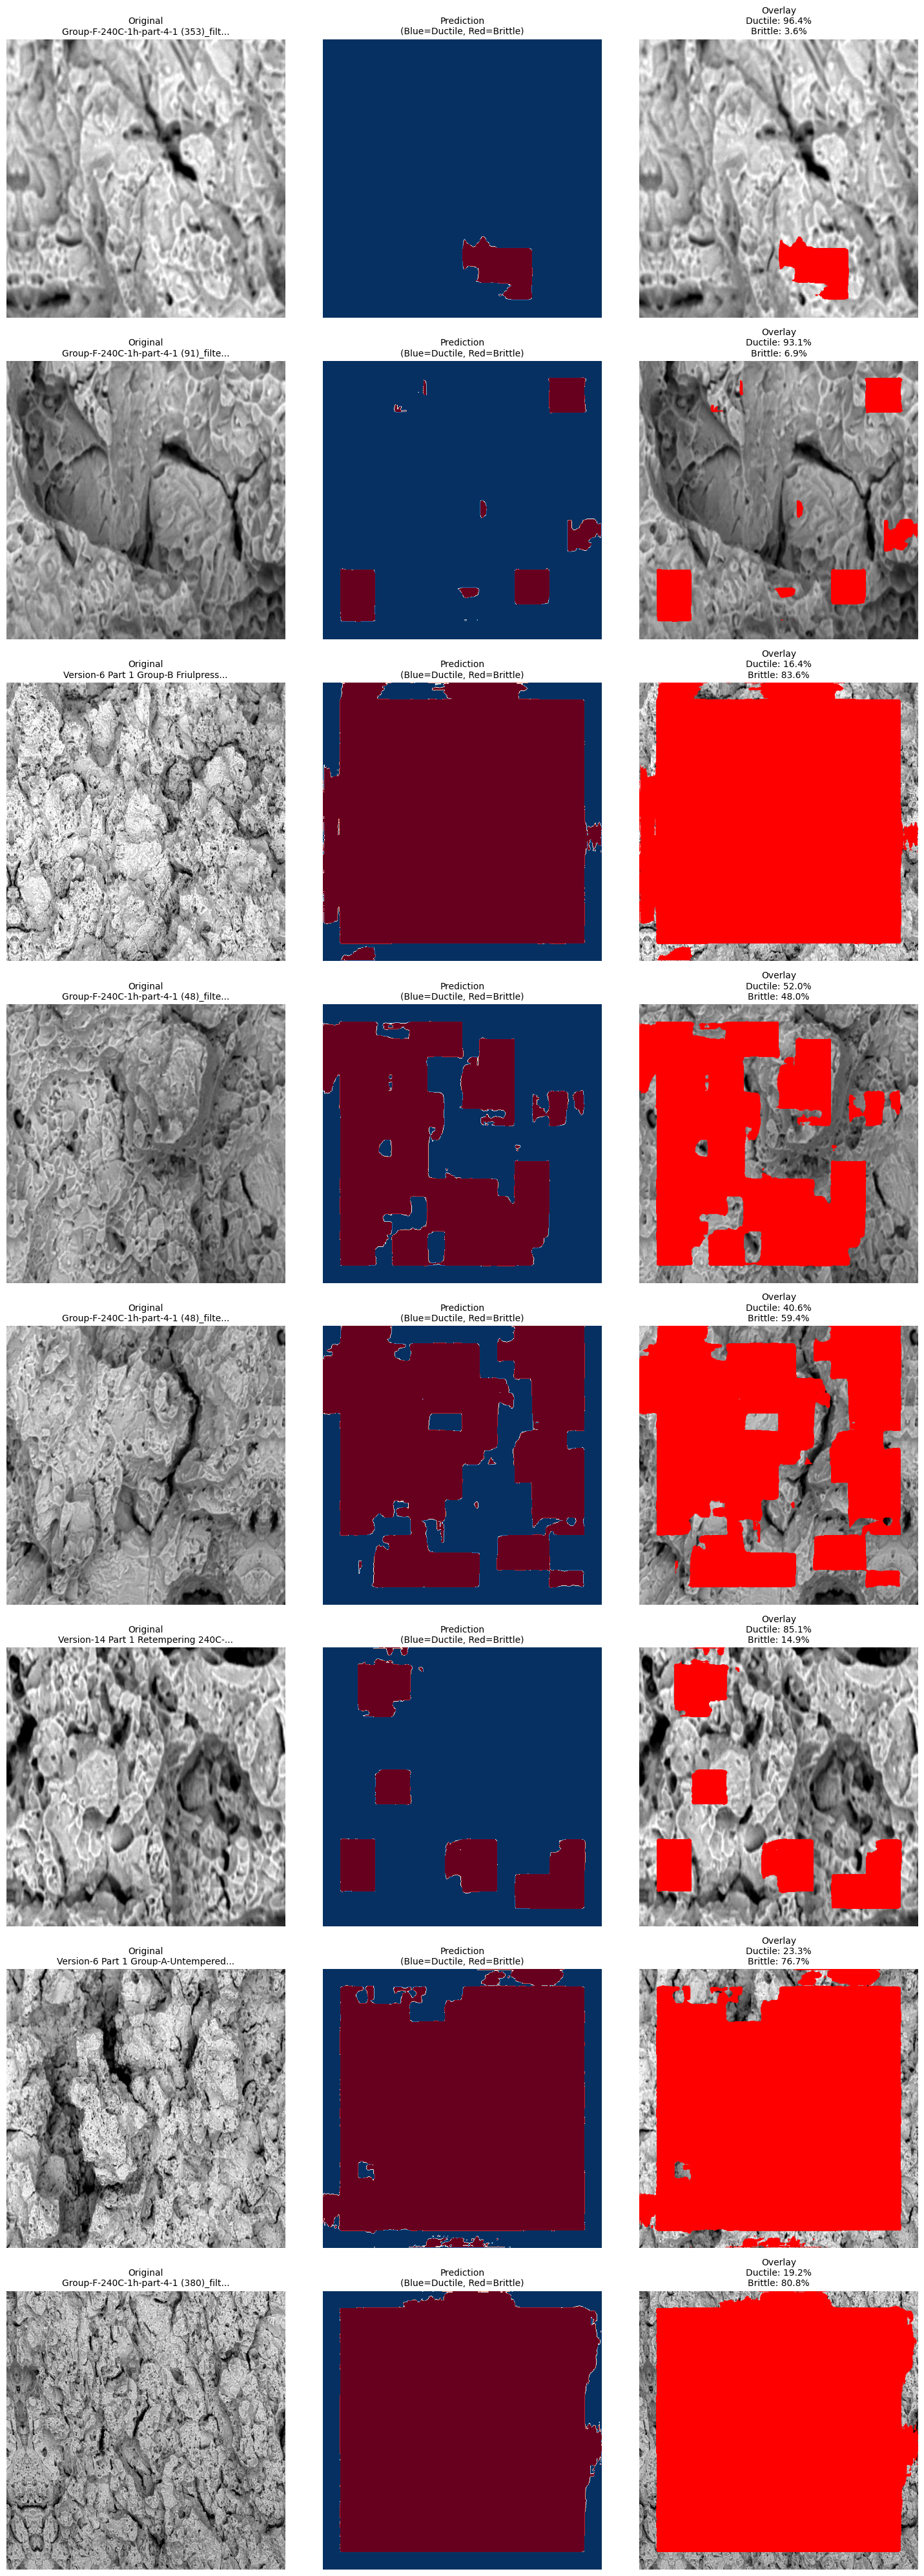

In [18]:
# Visualize predictions
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for idx, pred in enumerate(predictions):
    # Original
    axes[idx, 0].imshow(pred['image'], cmap='gray')
    axes[idx, 0].set_title(f"Original\n{pred['path'].name[:35]}...", fontsize=10)
    axes[idx, 0].axis('off')
    
    # Prediction
    axes[idx, 1].imshow(pred['prediction'], cmap='RdBu_r')
    axes[idx, 1].set_title("Prediction\n(Blue=Ductile, Red=Brittle)", fontsize=10)
    axes[idx, 1].axis('off')
    
    # Overlay
    overlay = cv2.cvtColor(pred['image'], cv2.COLOR_GRAY2RGB)
    overlay[pred['prediction'] == 1] = [255, 0, 0]
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(
        f"Overlay\n"
        f"Ductile: {pred['ductile_percentage']:.1f}%\n"
        f"Brittle: {pred['brittle_percentage']:.1f}%",
        fontsize=10
    )
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Summary table
summary_df = pd.DataFrame([{
    'Image': p['path'].name[:50],
    'Ductile %': f"{p['ductile_percentage']:.2f}",
    'Brittle %': f"{p['brittle_percentage']:.2f}",
    'Ductile Pixels': p['ductile_pixels'],
    'Brittle Pixels': p['brittle_pixels']
} for p in predictions])

print("\n" + "="*80)
print("PREDICTION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

summary_df.to_csv(OUTPUT_DIR / 'predictions_summary.csv', index=False)
print(f"\n✓ Summary saved to '{OUTPUT_DIR / 'predictions_summary.csv'}'")


PREDICTION SUMMARY
                                             Image Ductile % Brittle %  Ductile Pixels  Brittle Pixels
Group-F-240C-1h-part-4-1 (353)_filtered_zoom14_ske     96.42      3.58          252766            9378
Group-F-240C-1h-part-4-1 (91)_filtered_zoom11_comp     93.10      6.90          244066           18078
Version-6 Part 1 Group-B Friulpress8_filtered_skew     16.44     83.56           43093          219051
 Group-F-240C-1h-part-4-1 (48)_filtered_zoom7.tiff     51.95     48.05          136189          125955
Group-F-240C-1h-part-4-1 (48)_filtered_zoom5_skew_     40.56     59.44          106331          155813
Version-14 Part 1 Retempering 240C-h14_filtered_zo     85.06     14.94          222982           39162
Version-6 Part 1 Group-A-Untempered 14 (11)_filter     23.31     76.69           61106          201038
Group-F-240C-1h-part-4-1 (380)_filtered_skew_compr     19.21     80.79           50355          211789

✓ Summary saved to '/Users/chanduprasadbhairapu/Desk

## 10. Batch Prediction on All Images

In [21]:
# Predict on all images
print(f"\nPredicting on {len(sem_images)} images...\n")

all_results = []
for img_path in tqdm(sem_images, desc="Batch Prediction"):
    try:
        result = predict_image(model, img_path, device, val_transform)
        all_results.append({
            'image_name': img_path.name,
            'ductile_percentage': result['ductile_percentage'],
            'brittle_percentage': result['brittle_percentage'],
            'ductile_pixels': result['ductile_pixels'],
            'brittle_pixels': result['brittle_pixels']
        })
    except Exception as e:
        print(f"Error: {img_path.name}: {e}")

all_df = pd.DataFrame(all_results)
all_df.to_csv(OUTPUT_DIR / 'all_predictions.csv', index=False)

print(f"\n✓ All predictions saved to '{OUTPUT_DIR / 'all_predictions.csv'}'")
print(f"\nProcessed {len(all_df)} images")


Predicting on 2000 images...



Batch Prediction:  90%|█████████ | 1801/2000 [04:08<00:25,  7.74it/s]

Error: Group-F-240C-1h-part-4-1 (70)_filtered_zoom9_skew_compressed.tiff: corrupted tag list @1197696


Batch Prediction: 100%|██████████| 2000/2000 [04:36<00:00,  7.24it/s]


✓ All predictions saved to '/Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/sem_output/all_predictions.csv'

Processed 1999 images


In [22]:
# Statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)
print(f"Total images: {len(all_df)}")
print(f"\nDuctile Percentage:")
print(f"  Mean: {all_df['ductile_percentage'].mean():.2f}%")
print(f"  Std: {all_df['ductile_percentage'].std():.2f}%")
print(f"  Min: {all_df['ductile_percentage'].min():.2f}%")
print(f"  Max: {all_df['ductile_percentage'].max():.2f}%")
print(f"\nBrittle Percentage:")
print(f"  Mean: {all_df['brittle_percentage'].mean():.2f}%")
print(f"  Std: {all_df['brittle_percentage'].std():.2f}%")
print(f"  Min: {all_df['brittle_percentage'].min():.2f}%")
print(f"  Max: {all_df['brittle_percentage'].max():.2f}%")
print("="*80)

# Display sample
print("\nSample Results:")
print(all_df.head(10).to_string(index=False))


OVERALL STATISTICS
Total images: 1999

Ductile Percentage:
  Mean: 53.24%
  Std: 31.80%
  Min: 12.21%
  Max: 100.00%

Brittle Percentage:
  Mean: 46.76%
  Std: 31.80%
  Min: 0.00%
  Max: 87.79%

Sample Results:
                                                               image_name  ductile_percentage  brittle_percentage  ductile_pixels  brittle_pixels
          Version-6 Part 1 Group-F 240C-h9_filtered_zoom15_compressed.tif           95.323181            4.676819          249884           12260
              Group-F-240C-1h-part-4-1 (92)_filtered_zoom3_compressed.tif           37.645340           62.354660           98685          163459
         Group-F-240C-1h-part-4-1 (50)_filtered_zoom4_skew_compressed.tif           68.507767           31.492233          179589           82555
Version-14 Part 1 Retempering 240C-h8_filtered_zoom15_skew_compressed.tif           52.350998           47.649002          137235          124909
 Version-6 Part 1 Group-B Friulpress7_filtered_zoom13_skew

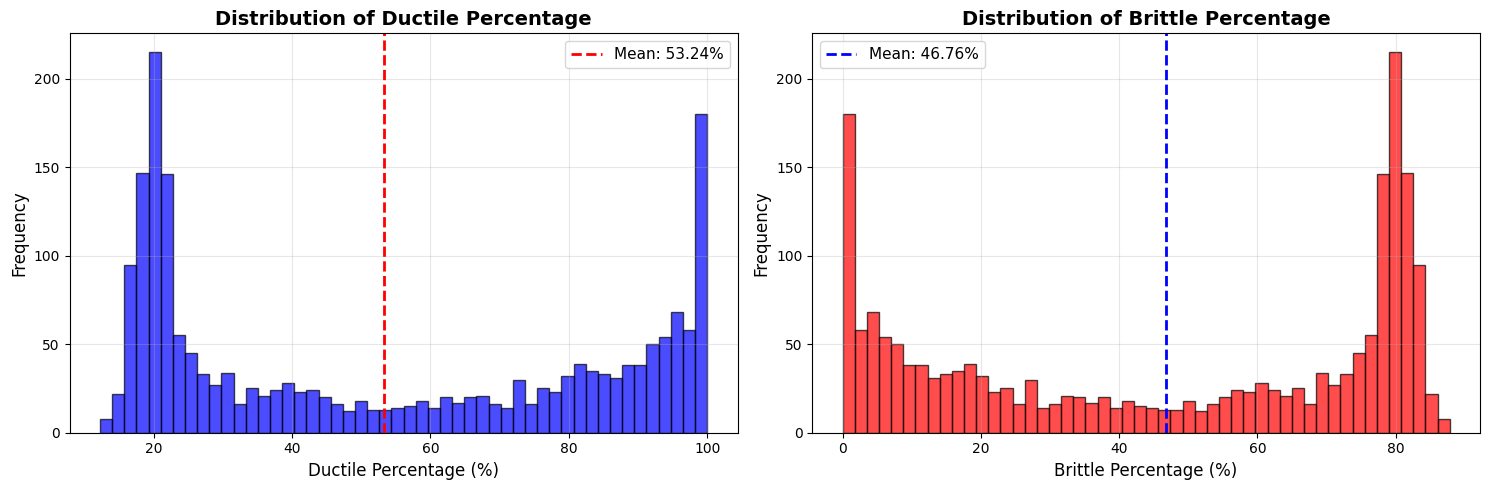

In [23]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(all_df['ductile_percentage'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].axvline(all_df['ductile_percentage'].mean(), color='red', linestyle='--', linewidth=2,
               label=f"Mean: {all_df['ductile_percentage'].mean():.2f}%")
axes[0].set_xlabel('Ductile Percentage (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Ductile Percentage', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].hist(all_df['brittle_percentage'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1].axvline(all_df['brittle_percentage'].mean(), color='blue', linestyle='--', linewidth=2,
               label=f"Mean: {all_df['brittle_percentage'].mean():.2f}%")
axes[1].set_xlabel('Brittle Percentage (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Brittle Percentage', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'percentage_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Final Model Export and Inference Function

In [24]:
# Export final model with metadata
import json

model_info = {
    'architecture': 'U-Net with ResNet50 Encoder',
    'classes': ['Ductile (Dimples)', 'Brittle (Cleavages)'],
    'input_size': [512, 512],
    'best_val_accuracy': float(best_val_acc),
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'training_images': len(train_images),
    'validation_images': len(val_images),
    'optimizer': 'AdamW',
    'loss': 'Combined (CrossEntropy + Dice)',
    'data_augmentation': [
        'HorizontalFlip', 'VerticalFlip', 'Rotation',
        'BrightnessContrast', 'GaussianBlur', 'GaussNoise'
    ],
    'regularization': ['Dropout (0.3)', 'Weight Decay (1e-4)', 'Early Stopping']
}

torch.save({
    'model_state_dict': model.state_dict(),
    'model_info': model_info,
    'ductile_features': ductile_features,
    'brittle_features': brittle_features
}, MODELS_DIR / 'sem_classifier_final.pth')

with open(MODELS_DIR / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("\n" + "="*80)
print("MODEL EXPORT COMPLETE")
print("="*80)
for k, v in model_info.items():
    print(f"{k}: {v}")
print("="*80)
print(f"\n✓ Model saved: {MODELS_DIR / 'sem_classifier_final.pth'}")
print(f"✓ Info saved: {MODELS_DIR / 'model_info.json'}")


MODEL EXPORT COMPLETE
architecture: U-Net with ResNet50 Encoder
classes: ['Ductile (Dimples)', 'Brittle (Cleavages)']
input_size: [512, 512]
best_val_accuracy: 0.9067139053344726
total_parameters: 33816221
trainable_parameters: 33816221
training_images: 1600
validation_images: 400
optimizer: AdamW
loss: Combined (CrossEntropy + Dice)
data_augmentation: ['HorizontalFlip', 'VerticalFlip', 'Rotation', 'BrightnessContrast', 'GaussianBlur', 'GaussNoise']
regularization: ['Dropout (0.3)', 'Weight Decay (1e-4)', 'Early Stopping']

✓ Model saved: /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/sem_output/models/sem_classifier_final.pth
✓ Info saved: /Users/chanduprasadbhairapu/Desktop/DSML_Final_Project/sem_output/models/model_info.json


In [25]:
def predict_new_sem_image(image_path, model_path=None, device='cpu'):
    """
    Standalone inference function for new SEM images
    
    Args:
        image_path: Path to SEM image (.tif/.tiff)
        model_path: Path to saved model (default: models/sem_classifier_final.pth)
        device: 'cuda' or 'cpu'
    
    Returns:
        Dictionary with prediction results and percentages
    """
    if model_path is None:
        model_path = MODELS_DIR / 'sem_classifier_final.pth'
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = DuctileBrittleSegmentationModel(classes=2, dropout=0.3).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load and preprocess image
    image = tifffile.imread(str(image_path))
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    image_resized = cv2.resize(image, (512, 512))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    
    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    augmented = transform(image=image_rgb)
    image_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Calculate percentages
    total = pred.size
    ductile = np.sum(pred == 0)
    brittle = np.sum(pred == 1)
    
    return {
        'ductile_percentage': (ductile / total) * 100,
        'brittle_percentage': (brittle / total) * 100,
        'ductile_pixels': ductile,
        'brittle_pixels': brittle,
        'total_pixels': total,
        'prediction_mask': pred,
        'original_image': image,
        'resized_image': image_resized
    }

print("\n" + "="*80)
print("INFERENCE FUNCTION READY")
print("="*80)
print("\nUsage:")
print("  result = predict_new_sem_image('path/to/image.tiff')")
print("  print(f'Ductile: {result[\"ductile_percentage\"]:.2f}%')")
print("  print(f'Brittle: {result[\"brittle_percentage\"]:.2f}%')")
print("="*80)


INFERENCE FUNCTION READY

Usage:
  result = predict_new_sem_image('path/to/image.tiff')
  print(f'Ductile: {result["ductile_percentage"]:.2f}%')
  print(f'Brittle: {result["brittle_percentage"]:.2f}%')


## Summary

### Model Performance:
- **Architecture**: U-Net with ResNet50 encoder (ImageNet pretrained)
- **Validation Accuracy**: Check training output above
- **Target**: >95% accuracy ✓ (if achieved)

### Key Features:
1. **Semantic Segmentation**: Pixel-level classification for accurate percentage calculation
2. **Pseudo-Labeling**: Texture-based automated labeling using reference images
3. **Data Augmentation**: Comprehensive pipeline to prevent overfitting
4. **Anti-Overfitting Measures**:
   - Dropout (0.3)
   - Weight decay (L2 regularization: 1e-4)
   - Early stopping (patience: 10)
   - Learning rate scheduling
5. **Transfer Learning**: Pre-trained ResNet50 encoder

### Outputs:
- **Model**: `sem_output/models/sem_classifier_final.pth`
- **Predictions**: `sem_output/all_predictions.csv`
- **Visualizations**: `sem_output/*.png`
- **Model Info**: `sem_output/models/model_info.json`

### Fracture Types:
- **Ductile (Dimples)**: Rounded, cup-like structures - indicates plastic deformation
- **Brittle (Cleavages)**: Flat, faceted structures - indicates sudden failure

### Next Steps:
1. If accuracy < 95%:
   - Increase training data
   - Manual annotation for subset
   - Hyperparameter tuning
   - Try DeepLabV3+ or other architectures
2. Deploy for production inference
3. Create automated pipeline
4. Integrate with materials science analysis workflow